In [283]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from src.utils import load_pickle, save_pickle
from src.model import get_embedding

In [285]:
# PATHS
RAW_DATA_PATH = '../data/raw/text_topics.pkl'
PROCESSED_DATA_PATH = '../data/processed/embedded.pkl'

## EDA & Data preprocessing

In [286]:
# unpickle the data
raw_data = load_pickle(RAW_DATA_PATH)
raw_data.head()

,text,date,topics,id
0,Barbara Bailey is the queen of broadcast news ...,2020-09-04,"[film_tv_&_video, news_&_social_concern]",1301943102094139393
1,start the 20-21 school year off POSITIVE! let’...,2020-09-05,"[diaries_&_daily_life, youth_&_student_life]",1302275052256342017
2,Worth watching at least the 1st 10mins if I wa...,2020-09-06,"[film_tv_&_video, news_&_social_concern]",1302450647422259205
3,There s regular people and then there s {@Bail...,2020-09-06,[celebrity_&_pop_culture],1302452496011595776
4,"Up with new grace, truly sorry on behalf of {@...",2020-09-06,"[celebrity_&_pop_culture, fitness_&_health, ne...",1302479114469867520


In [287]:
# drop the date and id columns
# I dont think date and id are relevant to classify the topic, it will only bias the model
# during inference date and id are going to be outside the distribution of the training data  
df = raw_data.drop(columns=["date", "id"])

In [288]:
# concatenate all topics lists into one list
topics = [topic for topics in df.topics for topic in topics]
# get unique topics
unique_topics = np.unique(topics)
print(unique_topics, f"there are {len(unique_topics)} unique topics")

['arts_&_culture' 'business_&_entrepreneurs' 'celebrity_&_pop_culture'
 'diaries_&_daily_life' 'family' 'fashion_&_style' 'film_tv_&_video'
 'fitness_&_health' 'food_&_dining' 'gaming' 'learning_&_educational'
 'music' 'news_&_social_concern' 'other_hobbies' 'relationships'
 'science_&_technology' 'sports' 'travel_&_adventure'
 'youth_&_student_life'] there are 19 unique topics


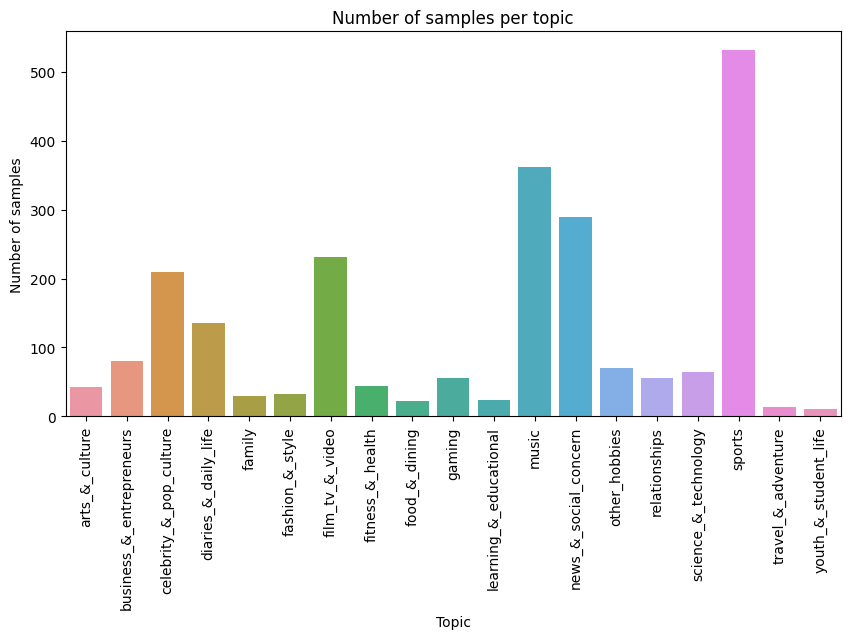

In [289]:
# get the number of samples for each topic and plot it 
topic_count = [len(df[df.topics.apply(lambda x: topic in x)]) for topic in unique_topics]
plt.figure(figsize=(10, 5))
sns.barplot(x=unique_topics, y=topic_count)
plt.xlabel("Topic")
plt.ylabel("Number of samples")
plt.xticks(rotation=90)
plt.title("Number of samples per topic")
plt.show()

In [324]:
topic_count

[42,
 80,
 210,
 135,
 30,
 33,
 231,
 44,
 22,
 56,
 23,
 362,
 289,
 70,
 55,
 65,
 532,
 14,
 11]

In [327]:
# will be use for balancing the loss function
weights = [1/t for t in topic_count]
weights = [w/sum(weights) for w in weights]

In [308]:
# one hot encode the topics column and store it in a list 
# this will be used to create the target column
topics_one_hot = []
for topics in df.topics:
    one_hot = [1 if topic in topics else 0 for topic in unique_topics]
    topics_one_hot.append(one_hot)
# create the target column
df["target"] = topics_one_hot

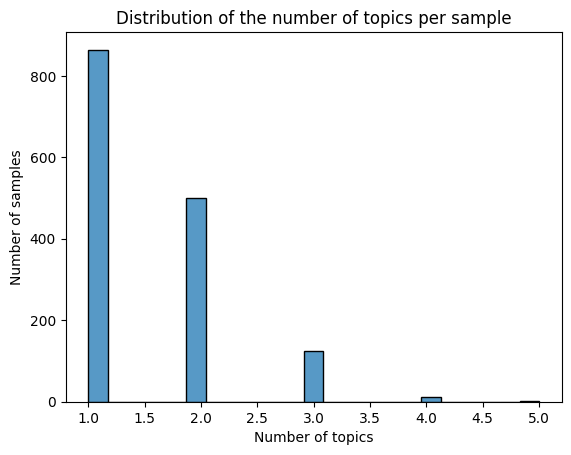

In [309]:
# what is the distribution of the number of topics per sample
sns.histplot(x=df.topics.apply(lambda x: len(x)))
plt.xlabel("Number of topics")
plt.ylabel("Number of samples")
plt.title("Distribution of the number of topics per sample")
plt.show()

In [ ]:
df.head()

In [ ]:
# data cleaning 
# remove username and url from the text
# remove emojis 

> one idea would be to use pre-trained LLMs to embed each tweet, we would than use these embeddings to train a classifier (a feed-forward neural network, SVM). 

In [ ]:
# get the embedding for each sample
embeddings = []
for text in df.text:
    try:
        embeddings.append(get_embedding(text))
    except:
        print("error !", "total embedded samples:", len(embeddings))
        # save the embeddings so far
        with open(f'../data/processed/{len(embeddings)}_embeddings.pkl', 'wb') as f:
            pickle.dump(embeddings, f)
        break

In [ ]:
# check that the number of embeddings is equal to the number of samples
assert len(embeddings) == len(df)
# add the embeddings to the dataframe
df["embedding"] = embeddings
## save the processed data
save_pickle(df, PROCESSED_DATA_PATH)

## Modeling

task : mutli-label classification (One Vs RestClassifier), we train a classifier for each label

experiment : Feedforward neural network on top of ada-002 embeddings

In [311]:
from src.model import DivideAndConquerFNN
from src.utils import split_data
from src.train import train
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

In [331]:
## load the processed data
df = load_pickle(PROCESSED_DATA_PATH)
x, y = df.embedding.to_list(), df.target.to_list()
x, y = np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y, test_size=0.2, val_size=0.1)
x_train, x_val, x_test, y_train, y_val, y_test = torch.tensor(x_train), torch.tensor(x_val), torch.tensor(x_test), torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)

In [313]:
input_dim = len(x_train[0])
hidden_dim = 16
number_of_labels = len(unique_topics)
classifier = DivideAndConquerFNN(input_dim, hidden_dim, number_of_labels)

batch_size = 16
num_epochs = 15

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

learning_rate = 3e-4
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# train the classifier
train(classifier, train_loader, val_loader, optimizer, criterion, weights, num_epochs, device)

In [333]:
y_pred = [[pred.item() for pred in res] for res in classifier(x_train)]
y_pred = (np.array(y_pred)>0.5).astype(int).T
y_truth = np.array(y_train)

print(classification_report(y_truth, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00       146
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00       163
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00        15
          11       0.96      0.91      0.93       258
          12       0.95      0.43      0.60       200
          13       0.00      0.00      0.00        44
          14       0.00      0.00      0.00        36
          15       0.00      0.00      0.00        42
          16       0.98      0.99      0.98       391
          17       0.00    

/home/hachem/miniconda3/envs/twitter-topic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hachem/miniconda3/envs/twitter-topic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> even with the weighted loss its not working 

Task : few-shot learning

Experiment : GPT-3

In [118]:
from src.model import GPT_3

In [348]:
prompt = lambda text : f"""
classify tweets to their topics, available topics are: ['arts_&_culture' 'business_&_entrepreneurs' 'celebrity_&_pop_culture'
 'diaries_&_daily_life' 'family' 'fashion_&_style' 'film_tv_&_video'
 'fitness_&_health' 'food_&_dining' 'gaming' 'learning_&_educational'
 'music' 'news_&_social_concern' 'other_hobbies' 'relationships'
 'science_&_technology' 'sports' 'travel_&_adventure'
 'youth_&_student_life']
tweet : Barbara Bailey is the queen of broadcast news in central & eastern Kentucky  After growing up watching her anchor the news, it was a great honor to call her coworker & friend. I loved saying “back to you, Barb” while reporting.  Cheers, {{USERNAME}} {{URL}} 
topics : ['film_tv_&_video','news_&_social_concern']
tweet : Saints defense was dinged for 4 missed tackles in Week 1, tying the Texans and Colts for the 6th fewest in the NFL  Saints defense credited with 8 pressures (3 sacks), a pressure rate of 20%. Ties Rams for 14th worst in Week 1  per ProFootballReference
topics : ['sports']
tweet : {text}
topics : [
"""
GPT_3(prompt(df.text[300]))

"    'business_&_entrepreneurs',\n    'sports'\n"

In [349]:
df.topics[300]

array(['sports'], dtype=object)

Task : text generation

Experiment : fine-tuning GPT-3 